In [458]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math


In [459]:
def p(img): #used for debugging
    x=3

In [460]:
def blur_image(image): #used for testing
    blur = cv2.GaussianBlur(image, (5,5), cv2.BORDER_DEFAULT)
    return image


In [461]:
def detect_salt_and_pepper(image):
    '''
        Input: image
            detects salt and pepper regardless of the image's brigtness
        output: boolean indicating if there is salt and pepper nosie
    '''
    height, width = image.shape[:2]
    noise_pixels = 0
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    #the idea is to loop through the pixels and compare each to the surrounding. this is probably not optimal performance wise but makes the program
    # generic. accurately detecting salt and pepper in images regardless of brightness and other noise (like sin)
    for i in range(1, height - 1):  
        for j in range(1, width - 1):  
            
            center_pixel = image[i, j]
            
            surrounding_pixels = [
                image[i-1, j-1], image[i-1, j], image[i-1, j+1], image[i, j-1], 
                image[i, j+1], image[i+1, j-1], image[i+1, j], image[i+1, j+1]] 
            
            x=0
            #stack-like way to compare the pixel to its surroundings. remember the image was thresholded so the pixels are black and white only
            for k in range(0,7): 
                if surrounding_pixels[k] == center_pixel:
                    x+=1
                else:
                    x-=1

            if x < 0:
                noise_pixels += 1 

    image_size = height*width
    percentage_noise = 100*noise_pixels / (height*width) #compare salt/pepper pixels to total pixels. to calculate an approximate percentage
    print(f"Total pixels in image:  {image_size}")
    print(f"Total noisy pixels: {noise_pixels}")
    print(f"Salt and Pepper approximate percentage: {percentage_noise} %")

    return percentage_noise > 2 

In [462]:
def add_salt_and_pepper(image): #for testing
    noiseProb = 0.15
    noise = np.random.rand(image.shape[0], image.shape[1])
    image[noise < noiseProb/2] = 0
    image[noise > 1 - noiseProb/2] = 255

    return image

In [463]:
def fix_salt_and_pepper(image): 
    
    #kernel = np.array([[1/5], [1/5], [1/5]])
    #image = cv2.filter2D(image,-1,kernel)
    image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
    _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) 

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)) 
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations = 1)
    
    #unused logic
    #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 10)) 
    #image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations = 3)
    #display(image, "1")
    
    #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
    #image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    #display(image, "2")
    
    return image

In [464]:
def change_brightness(image): #used for testing
    min_value = 50
    max_value = 200
    image = np.clip(image, 0, 255).astype(np.uint8)

    stretched_image = np.uint8((image / 255) * (max_value - min_value) + min_value)
    
    return stretched_image

In [465]:
def get_thresh_value(img): #unused logic
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    peaks = np.argsort(hist.flatten())[-2:]
    thresh_value = (peaks[0]+peaks[1])/2

    _, thresholded = cv2.threshold(img, thresh_value+5, 255, cv2.THRESH_BINARY)
    plt.figure()
    plt.plot(hist)
    plt.scatter(peaks, hist[peaks], color='r', label='Peaks')
    plt.title("Histogram with Peaks")
    plt.legend()
    plt.show()
    return thresholded#, thresh_value

In [466]:

def plotImage(image, Final):
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Test Case')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Final, cmap='gray')
    plt.title('final_result')
    plt.axis('off')

    plt.show()

In [467]:
def detect_distance_between_lines(gray):
    '''
        Input: image
            finds the barcode from the image to be ready for decoding
        output: max distance between bars. used to dilate the barcode to make it 1 object
    '''

    #Thresholding the grayscale image to create a binary image. Inverts the binary image
    # This is done because we are interested in detecting the white bars on a dark background (barcode).
    _, binary_image = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)  

    # apply canny edge detection
    edges = cv2.Canny(binary_image, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines in the edge-detected image
    # HoughLinesP is a probabilistic version of the Hough Line Transform that returns a list of lines.
    # 1 is the resolution of the accumulator in pixels.
    # np.pi / 180 is the resolution of the angle in radians.
    # The threshold is the minimum number of intersections in the accumulator to detect a line.
    # minLineLength: minimum length of a line to be detected.
    # maxLineGap: maximum gap between lines to be considered as a single line.
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)

    # Make a copy of the grayscale image to draw lines on
    line_image = np.copy(gray)

    if lines is not None:
        # Sort by x
        lines = sorted(lines, key=lambda x: x[0][0])

        distances = [] 
        maxdistance = 0 

        # loop through the sorted lines and calculate distances between consecutive lines
        for i in range(1, len(lines)):
            x1, y1, x2, y2 = lines[i-1][0]  
            x3, y3, x4, y4 = lines[i][0] 

            # Check if the current line is approximately parallel to the previous line to filter irregular lined
            if abs(x3 - x1) == abs(x4 - x2):
                
                distance = abs(x3 - x1)
                
                if distance > maxdistance:
                    maxdistance = distance

                distances.append(distance)
            
            #cv2.line(line_image, (x1, y1), (x2, y2), 1)  
            #cv2.line(line_image, (x3, y3), (x4, y4), 1)

        print(f"Distance between barcode bars: {maxdistance}")
        return maxdistance

    else:
        print("No lines detected.")
        return -1

In [468]:
def detectBarcode(img):
    '''
        Input: image
            finds the barcode from the image to be ready for decoding
        output: extracted barcode
    '''
    #maxdistance  is max distance between bars. this is used to open the barcode to make is 1 object (largest contour)
    maxdistance = detect_distance_between_lines(img)
    #print(maxdistance)

    #use a structuring element based on the distance between bars to open the barcode horizontally. maxdistance is required for the code to not be test cae deppendant.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (maxdistance+1, 1)) #+1 3shan maxdistance is 1 pixel short
    closed_image = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    #apply thresholding 
    _, closed_image_2 = cv2.threshold(closed_image, 150, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(closed_image_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = None
    max_area = 0

    #loop through contours to find the largest one which is the barcode
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            largest_contour = contour

    #use the dimensions of the contour to crop the barcode from the original image
    x, y, deltax, deltay = cv2.boundingRect(largest_contour)
    mabrook = img[y:y+deltay, x:x+deltax]
    
    return mabrook

In [469]:
def detect_contrast(image): #not used

    mean, stddev = cv2.meanStdDev(image)

    mean = mean[0][0]
    stddev = stddev[0][0]

    print(f"Mean intensity: {mean}")
    print(f"Standard Deviation: {stddev}")

    contrast_ratio = stddev / mean

    print(f"Contrast Ratio (stddev / mean): {contrast_ratio}")

    if contrast_ratio < 0.1:  # Example
        print("The image has low contrast.")
        return True  # Low
    else:
        print("The image has sufficient contrast.")
        return False  # High

In [470]:
def fix_contrast(gray): #not used
    
    min_intensity = np.min(gray)
    max_intensity = np.max(gray)

    stretched_image = (gray - min_intensity) * (255 / (max_intensity - min_intensity))

    return stretched_image.astype(np.uint8)

In [471]:

def decode(out):
    # 0 means narrow, 1 means wide
    NARROW = "0"
    WIDE = "1"
    code11_widths = {
        "00110": "Stop/Start",
        "10001": "1",
        "01001": "2",
        "11000": "3",
        "00101": "4",
        "10100": "5",
        "01100": "6",
        "00011": "7",
        "10010": "8",
        "10000": "9",
        "00001": "0",
        "00100": "-",
    }

    # Get the average of each column in your image
    mean = out.mean(axis=0)
    
    # Set it to black or white based on its value
    mean[mean <= 127] = 1
    mean[mean > 128] = 0

    # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    # Need to figure out how many pixels represent a narrow bar
    narrow_bar_size = 0
    found_a_one = 0
    for pixel in pixels:
        if pixel == "0" and found_a_one == 0:
            continue
        if pixel == "1":
            found_a_one = 1
            narrow_bar_size += 1
        else:
            break

    wide_bar_size = narrow_bar_size * 2
    
    print(f"narrow: {narrow_bar_size}, wide: {wide_bar_size}")

    print(mean)

    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False

    pixels = pixels.lstrip('0')
    
    while pixel_index < len(pixels):

        if skip_next:
            pixel_index += narrow_bar_size
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except:
            pass
        pixel_index += 1

        tolerance = narrow_bar_size // 2

        current_digit_widths += NARROW if narrow_bar_size - tolerance <= count <= narrow_bar_size + tolerance else WIDE

        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True  # Next iteration will be a separator, so skip it

    print(digits)

In [472]:
def detect_rotation(image): 
    '''
        Input: image
            detects the required angle of rotation (could be zero)
        output: angle and a boolean indicating the orientation since minArearect returns angle in limited range
    '''
    
    # Step 1: Perform edge detection using the Canny algorithm
    #  - 50: the lower threshold for the hysteresis procedure 
    #  - 200: the upper threshold
    edges = cv2.Canny(image, 50, 200)

    # Step 2: Find contours in the edge-detected image
    # cv2.RETR_EXTERNAL means to only retrieve the outermost contours (useful for detecting the main object)
    # cv2.CHAIN_APPROX_SIMPLE helps to compress horizontal, vertical, and diagonal segments and stores only their end points
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 3: Identify the largest contour based on area
    # max(contours, key=cv2.contourArea) returns the contour with the maximum area (barcode)
    # cv2.contourArea() is a function that computes the area of a contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Step 4: Get the minimum enclosing rectangle for the largest contour
    # cv2.minAreaRect returns a rotated rectangle that encloses the contour with the least area
    # It provides the center (x, y) and the rotation angle of the rectangle
    min_rect = cv2.minAreaRect(largest_contour)

    angle = min_rect[2]
    points = cv2.boxPoints(min_rect)
    
    #the 4 corner points are ordered clockwise starting from the point with the highest y (aktar no2ta south).
    #so the rule is to compare point 0 to point 1 and 3 to determine if its 45 or -45 (kda / walla kda \)

    point0 = points[0]
    point1 = points[1]
    point3 = points[3]
    
    distance1 = np.linalg.norm(point1 - point0) #euclidian (pythagoras)
    distance2 = np.linalg.norm(point3 - point0)

    return angle, distance1 < distance2

In [473]:
def rotate(img, angle, rotPoint=None):
    (height, width) = img.shape[:2] #first 2 values

    if rotPoint is None:
        rotPoint = (width//2, height//2)
    
    rotMat = cv2.getRotationMatrix2D(rotPoint, angle, 1.0) #1.0 is rescale parameter
    dimensions = (width, height)

    return cv2.warpAffine(image, rotMat, dimensions, flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

In [474]:
def extract_grayscale_regions_hsv(input_img, saturation_threshold=30):
    """ Extract grayscale regions from an image using low saturation in the HSV color space."""
    # Convert the image to HSV color space
    hsv_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2HSV)
    
    # Split the HSV channels
    h, s, v = cv2.split(hsv_img)
    
    # Create a mask for low-saturation regions
    low_saturation_mask = s < saturation_threshold
    
    # Convert the mask to binary
    binary_mask = low_saturation_mask.astype(np.uint8) * 255
    
    # Create a white background
    white_background = np.ones_like(input_img, dtype=np.uint8) * 255 
    
    # Use the mask to isolate low-saturation regions (grayscale)
    grayscale_regions = cv2.bitwise_and(input_img, input_img, mask=binary_mask)
    
    # Invert the mask
    inverted_mask = cv2.bitwise_not(binary_mask)
    grayscale_regions += cv2.bitwise_and(white_background, white_background, mask=inverted_mask)
    
    return grayscale_regions

In [475]:
def Handle_rotation(image):
    '''
        Input: image
            detects the required angle of rotation (could be zero)
        output: rotated image
    '''
    #Pad the image to remove issues resulting from the barcode being positioned in such a way that it intersects with the border of the image
    padded_image = cv2.copyMakeBorder(image, 50, 50, 50, 50, cv2.BORDER_CONSTANT, value=(255, 255, 255))

    #detect rotation angle
    angle, pos = detect_rotation(padded_image)

    #pos means 2 things, either 45(/) or barcode is horizontal if angle is 90
    if angle == 90:
        if pos:
            return image #no need
        else:
            image = rotate(image, -90) #barcode is vertical
            return image

    (h, w) = padded_image.shape[:2]
    center = (w // 2, h // 2)

    if pos: #properly adjust angle if needed
        angle-=90

    M = cv2.getRotationMatrix2D(center, angle, 1.0) 
    
    image = cv2.warpAffine(padded_image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)


    return image

In [476]:
def preprocess(image):

    #Step 1: Extract grayscale regions from an image using low saturation in the HSV color space
    isolated = extract_grayscale_regions_hsv(image, saturation_threshold=30)

    #Step 2: Convert the image to grayscale
    image = cv2.cvtColor(isolated, cv2.COLOR_BGR2GRAY)

    #Step 3: Analyze radial profile to check peaks in the frequency spectrum
    image = analyze_radial_profile(image)

    #Step 4: Blur the image to reduce noise using an average 3x1 kernel.
    kernel = np.array([[1/3], [1/3], [1/3]])
    blurred = cv2.filter2D(image,-1,kernel)
    p(blurred)

    #Step 5: Detect and Fix Salt and Pepper. 
    if detect_salt_and_pepper(blurred):
        blurred = fix_salt_and_pepper(blurred)
    
    #Step 6: Thresholding to separate the barcode from the background. 
    _, binary_img = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    p(binary_img)

    #Step 7: Detect the rotaion angle of the barcode and rotate accordingly
    binary_img = Handle_rotation(binary_img)
    p(binary_img)

    #Step 8: Extract the barcode from the image
    barcode = detectBarcode(binary_img)
    p(barcode)

    #Step 9: Apply median bluring and morphological opening vertically to optimize extracted barcode
    w, h = barcode.shape[:2]
    blured_barcode = cv2.medianBlur(cv2.blur(barcode,(1,h)),1) #average in vertical direction to dillute white pixels in bars, black pixels in spaces
    _, binary_barcode = cv2.threshold(blured_barcode, 200, 255, cv2.THRESH_BINARY) #threshold to remove gray (dilluted) pixels
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, h)) 
    final = cv2.morphologyEx(binary_barcode, cv2.MORPH_OPEN, kernel) #connect bars
    
    p(final)
    return final





In [477]:
def radial_profile(data, center):
    '''
        Input:
            data: 2D array (e.g., magnitude spectrum of an image)
            center: Tuple (x, y) representing the center of the array
        Output:
            radial_profile: 1D array representing the average values along concentric circles
                           radiating outward from the center
    '''
    # grid of coordinates for data
    y, x = np.indices(data.shape)  
    
    #calculate tradii (distance from center)
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)  
    
    r = r.astype(int)  

    # Sum the values of data in each radius bin
    radial_sum = np.bincount(r.ravel(), data.ravel())  
    
    # Count the number of pixels in each radius bin
    radial_count = np.bincount(r.ravel())  
    
    # Compute the average value for each radius by dividing the sum by the count
    radial_profile = radial_sum / radial_count 

    return radial_profile


In [478]:
def analyze_radial_profile(image):
    '''
        Input: image
            Removes sine wave noise by detecting above-average intensities along radii from the center 
            in the frequency domain. Noise is removed using adaptive thresholding if a peak is detected.
        Output: Image denoised from sine wave noise
    '''
    # Fourier Transform to convert the image to the frequency domain
    F = np.fft.fft2(image)
    Fshift = np.fft.fftshift(F)  # Shift the zero-frequency component to the center of the spectrum

    # Calculate the magnitude spectrum (absolute values of the frequency domain representation)
    magnitude_spectrum = np.abs(Fshift)

    # Find the center of the magnitude spectrum
    center = (magnitude_spectrum.shape[0] // 2, magnitude_spectrum.shape[1] // 2)

    # Compute the radial profile, which represents intensity along radii from the center
    radial_profile_data = radial_profile(magnitude_spectrum, center)

    # Initialize a variable to indicate whether a peak in the radial profile is found
    peak_found = 0

    for i in range(1, len(radial_profile_data) - 1): #start from second (ignore center)
        diff = radial_profile_data[i+1] - radial_profile_data[i]  
        if diff > 5e+05:  # Check if the difference between raddii exceeds the threshold (sudden change means peak -> noise)
            peak_found = 1 
            peak = radial_profile_data[i] 
            break  

    # apply adaptive thresholding to remove sine wave noise
    if peak_found:
        print(f"Peak frequency in the radial profile is at: {peak}")
        return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 25, 9)

    
    return image




Test Case 1
Relevant information:
Total pixels in image:  480000
Total noisy pixels: 447
Salt and Pepper approximate percentage: 0.093125 %
Distance between barcode bars: 8


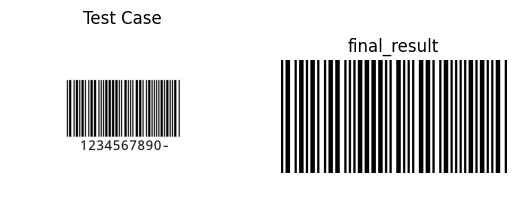

narrow: 4, wide: 8
[1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0

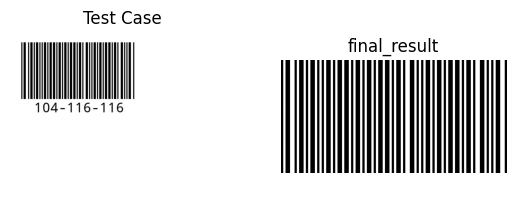

narrow: 4, wide: 8
[1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1

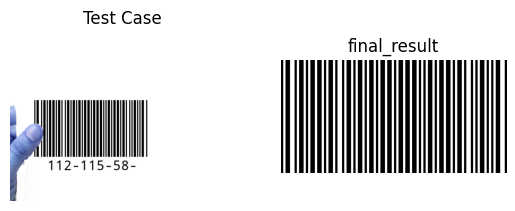

narrow: 4, wide: 8
[1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0

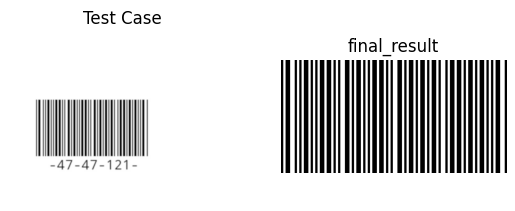

narrow: 4, wide: 8
[1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1

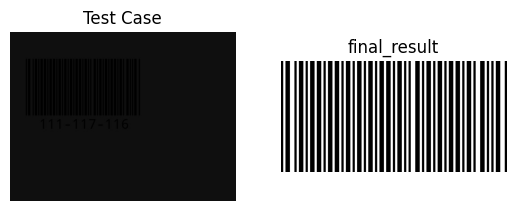

narrow: 4, wide: 8
[1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0

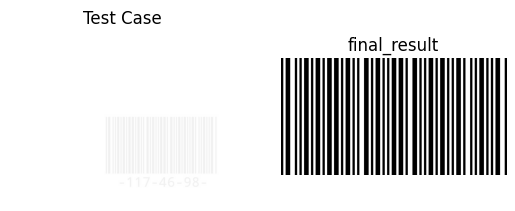

narrow: 4, wide: 8
[1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0

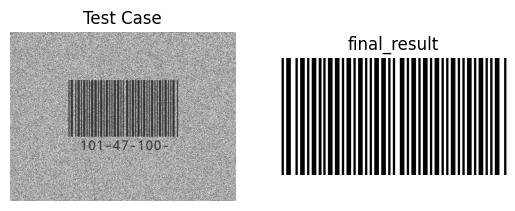

narrow: 4, wide: 8
[0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.
 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1

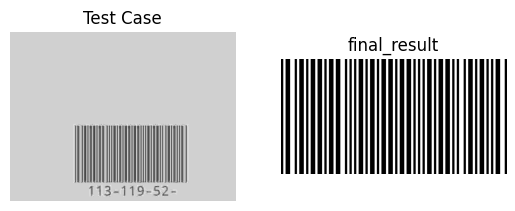

narrow: 4, wide: 8
[1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1

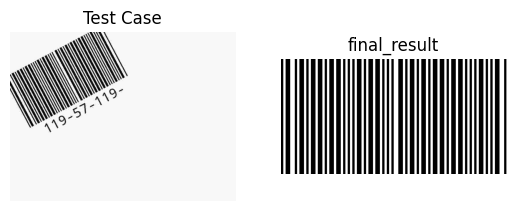

narrow: 4, wide: 8
[1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1

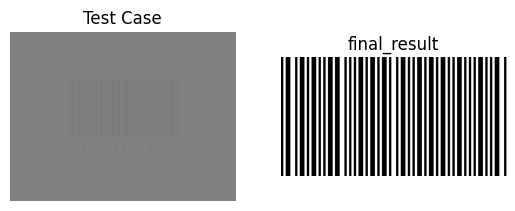

narrow: 4, wide: 8
[1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1

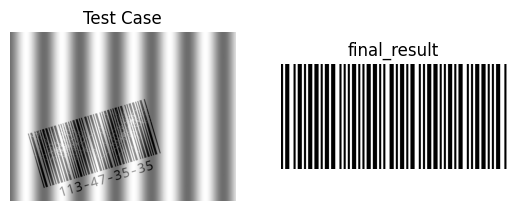

narrow: 4, wide: 8
[1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1

In [479]:
test_cases = {
    'Test Cases/01 - lol easy.jpg': ['Stop/Start', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '-', 'Stop/Start'],
    'Test Cases/02 - still easy.jpg': ['Stop/Start', '1', '0', '4', '-', '1', '1', '6', '-', '1', '1', '6', 'Stop/Start'],
    'Test Cases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg': ['Stop/Start', '1', '1', '2', '-', '1', '1', '5', '-', '5', '8', '-', 'Stop/Start'],
    'Test Cases/04 - fen el nadara.jpg': ['Stop/Start', '-', '4', '7', '-', '4', '7', '-', '1', '2', '1', '-', 'Stop/Start'],
    'Test Cases/05 - meen taffa el nour!!!.jpg': ['Stop/Start', '1', '1', '1', '-', '1', '1', '7', '-', '1', '1', '6', 'Stop/Start'],
    'Test Cases/06 - meen fata7 el nour 333eenaaayy.jpg': ['Stop/Start', '-', '1', '1', '7', '-', '4', '6', '-', '9', '8', '-', 'Stop/Start'],
    'Test Cases/07 - mal7 w felfel.jpg': ['Stop/Start', '1', '0', '1', '-', '4', '7', '-', '1', '0', '0', '-', 'Stop/Start'],
    'Test Cases/08 - compresso espresso.jpg': ['Stop/Start', '1', '1', '3', '-', '1', '1', '9', '-', '5', '2', '-', 'Stop/Start'],
    'Test Cases/09 - e3del el soora ya3ammm.jpg': ['Stop/Start', '1', '1', '9', '-', '5', '7', '-', '1', '1', '9', '-', 'Stop/Start'],
    'Test Cases/10 - wen el kontraastttt.jpg': ['Stop/Start', '1', '0', '3', '-', '1', '2', '0', '-', '9', '9', '-', 'Stop/Start'],
    'Test Cases/11 - bayza 5ales di bsara7a.jpg': ['Stop/Start', '1', '1', '3', '-', '4', '7', '-', '3', '5', '-', '3', '5', 'Stop/Start'],
}                            

count = 1

for path, barcode in test_cases.items():
    print(f"Test Case {count}")
    print("Relevant information:")
    count = count + 1

    image = cv2.imread(path)
    Final = preprocess(image) 
    plotImage(image, Final) 

    decode(Final)

    print(f"Correct code:")
    print(barcode)
    print("*******************************************************************************")
